<a href="https://colab.research.google.com/github/Samarth-991/Pose-Estimation/blob/main/Hand_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 
import os 
import tqdm
import cv2 
from google.colab.patches import cv2_imshow
import time
from matplotlib import pyplot as plt 

# install media pipe
# ! pip install mediapipe 
import mediapipe as mp
# Download the video
hand_video = '/content/handpose.mp4'

## Hand Position Estimation 
To detect initial hand locations, we designed a single-shot detector model optimized for mobile real-time uses in a manner similar to the face detection model in MediaPipe Face Mesh. Detecting hands is a decidedly complex task: our lite model and full model have to work across a variety of hand sizes with a large scale span (~20x) relative to the image frame and be able to detect occluded and self-occluded hands. 

![picture](https://media.geeksforgeeks.org/wp-content/uploads/20210802154942/HandLandmarks.png)

In [7]:
mphands = mp.solutions.hands # hands model 
mpdraw = mp.solutions.drawing_utils

In [2]:
from IPython.display import HTML
from base64 import b64encode
see_video = True
if see_video:
    mp4 = open(hand_video,'rb').read()
    decoded_vid = "data:video/mp4;base64," + b64encode(mp4).decode()
    HTML(f'<video width=400 controls><source src={decoded_vid} type="video/mp4"></video>')

In [9]:
# Open the video.
video_cap = cv2.VideoCapture(hand_video)

# Get some video parameters to generate output video with classificaiton.
video_n_frames = video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
video_fps = video_cap.get(cv2.CAP_PROP_FPS)
video_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print("Video Frames: {}".format(video_n_frames))
print("video FPS: {}".format(video_fps))
print("Shape: {}x{}".format(video_width,video_height))
print("video length {} seconds".format(video_n_frames//video_fps))

Video Frames: 203.0
video FPS: 10.036917397323489
Shape: 640x480
video length 20.0 seconds


In [10]:
out_video_path = '/content/output_hand_sample.mp4'
out_video = cv2.VideoWriter(out_video_path, cv2.VideoWriter_fourcc(*'MP4V'), video_fps, (video_width, video_height))

with mphands.Hands(min_detection_confidence=0.8,min_tracking_confidence=0.5) as hands:
    while True:
        success,input_frame = video_cap.read()
        if not success:
            break 
        # run Pose detection/tracker
        input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
        # input_frame.flags.writable = False
        results = hands.process(image=input_frame)
        # input_frame.flags.writeable = True
        hand_landmarks = results.multi_hand_landmarks
        # make a copy of input frame
        output_frame = input_frame.copy()
        if hand_landmarks is not None:
            for num, hand in enumerate(hand_landmarks):
                mpdraw.draw_landmarks(output_frame,
                                      hand,
                                      mphands.HAND_CONNECTIONS)
        # Save the output frame.
        out_video.write(cv2.cvtColor(np.array(output_frame), cv2.COLOR_BGR2RGB))

    video_cap.release()
    out_video.release()
    cv2.destroyAllWindows()        

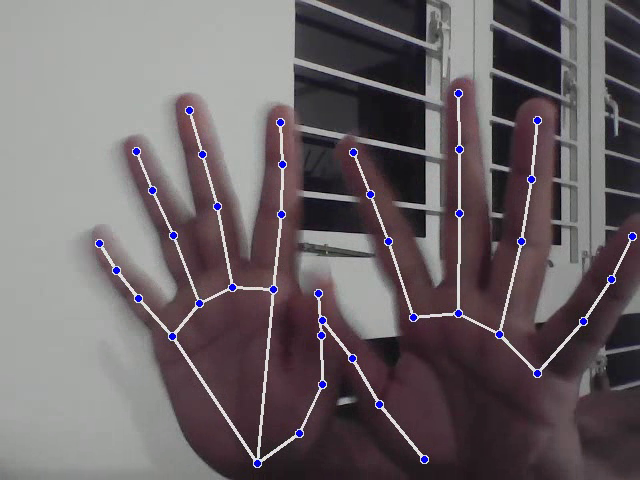

In [11]:
## show a random frame
out_cap = cv2.VideoCapture(out_video_path)
out_cap.set(cv2.CAP_PROP_POS_MSEC,np.random.randint(1500,15000)) # cue to any random second 
while True:
    success,input_frame = out_cap.read()
    if not success:
        break
    cv2_imshow(input_frame)
    break

## Detect Left and Right Hand

The left and Right hand is detected by Mediapipe using hand.multi_handedness

In [ ]:
# last frame of the results 
# will render left and right from the Wrist 
print("point for 1st hand\n{}".format(hand_landmarks[0].landmark[mphands.HandLandmark.WRIST]))

# the multihandedness produces the left and right with index
for r in results.multi_handedness:
    print(r.classification[0])

In [3]:
class HandPose_estimator:
    def __init__(self,video_path,
                 overlay = True,
                 multi_hand = True,
                 detection_thresh=0.8,
                 tracking_thresh=0.5,
                 out_path='output.mp4'):
        self.video_path = video_path
        self.out_path = out_path
        self.detection_cnf = 0.8
        self.tracking_cnf = 0.5
        self.mphands = mp.solutions.hands # hands model 
        self.mpdraw = mp.solutions.drawing_utils
        self.output_frame = None
       
    def read_video_parms(self):
        # Open the video.
        self.video_cap = cv2.VideoCapture(self.video_path)
        # Get some video parameters to generate output video with classificaiton.
        self.video_n_frames = self.video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
        self.video_fps = self.video_cap.get(cv2.CAP_PROP_FPS)
        self.video_width = int(self.video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.video_height = int(self.video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        return
    
    def get_label(self,index,hand,results,img_shape=(640,480)):
        output=None
        for idx ,classification in enumerate(results.multi_handedness):
            if classification.classification[0].index == index:    
                # process results
                label_idx = classification.classification[0].label
                score = classification.classification[0].score
                text = "{} {}".format(label_idx,round(score,2))

                # extract cords  
                cords =tuple( [int(img_shape[0]*hand.landmark[self.mphands.HandLandmark.WRIST].x) ,
                               int(img_shape[1]*hand.landmark[self.mphands.HandLandmark.WRIST].y)
                              ])
                output = text,cords
        return output

    def detect(self):
        # read video parameters
        self.read_video_parms()
        # set output video writer 
        self.out_video = cv2.VideoWriter(self.out_path, cv2.VideoWriter_fourcc(*'MP4V'), 
                                         self.video_fps, (self.video_width, self.video_height))
        
        with self.mphands.Hands(min_detection_confidence=self.detection_cnf,
                           min_tracking_confidence=self.tracking_cnf) as hands:
            while True:
                success,input_frame = self.video_cap.read()
                if not success:
                    break 
                input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
                # input_frame.flags.writable = False
                results = hands.process(image=input_frame)
                # input_frame.flags.writeable = True
                hand_landmarks = results.multi_hand_landmarks
                self.output_frame = input_frame.copy()
                if hand_landmarks is not None:
                    for num, hand in enumerate(hand_landmarks):
                        output = self.get_label(num,hand,results,img_shape=(self.video_width,self.video_height))
                        self.mpdraw.draw_landmarks(self.output_frame,hand,self.mphands.HAND_CONNECTIONS)
                        if output is not None:
                            self.output_frame = cv2.putText(self.output_frame, output[0], output[1], 
                                                            cv2.FONT_HERSHEY_SIMPLEX,0.5, (255,0, 255),1,2)
                self.out_video.write(cv2.cvtColor(np.array(self.output_frame), cv2.COLOR_BGR2RGB))
        self.video_cap.release()
        self.out_video.release()
        cv2.destroyAllWindows()

In [4]:
out_video_path = '/content/output_hand_sample_02.mp4'
handpose_detector = HandPose_estimator(hand_video,out_path=out_video_path)
handpose_detector.detect()

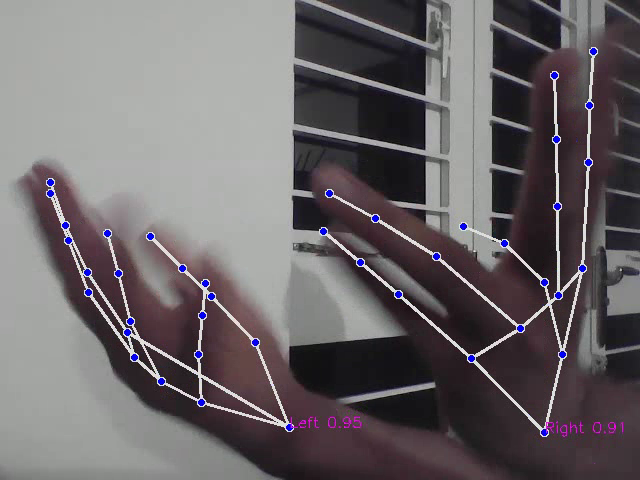

In [5]:
## show a random frame
out_cap = cv2.VideoCapture(out_video_path)
out_cap.set(cv2.CAP_PROP_POS_MSEC,np.random.randint(1500,15000)) # cue to any random second 
while True:
    success,input_frame = out_cap.read()
    if not success:
        break
    cv2_imshow(input_frame)
    break

## Find Angles

In [1]:
joint_list = [[8,7,6],[12,11,10]]

def get_angles(image,results,joint_list):
    for  hand in results.multi_hand_landmarks:
        for joint in joint_list:
            a = np.array(hand.landmark[joint[0]].x, hand.landmark[joint[0]].y)
            b = np.array(hand.landmark[joint[1]].x, hand.landmark[joint[1]].y)
            c = np.array(hand.landmark[joint[2]].x, hand.landmark[joint[2]].y)

            # get angle in radians 
            radian = np.arctan2(c[1]-b[1],c[0]-b[0]) - np.arctan2(a[1]-b[1],a[0]-b[0])
            angle = np.abs(radian*180.0/np.pi)
            if angle>180.0:
                angle = 360-angle
            cv2.putText(image,str(round(angle,2)),tuple(np.multiply(b,[640,480]).astype(int)),
                        cv2.FONT_HERSHEY_SIMPLEX,0.5, (255, 255, 255),1,2)
    return image

In [21]:
class HandPose_estimator_with_angle:
    def __init__(self,video_path,
                 overlay = True,
                 multi_hand = True,
                 detection_thresh=0.8,
                 tracking_thresh=0.5,
                 fingers = [[8,7,6],[12,11,10]],
                 out_path='output.mp4'):
        
        self.video_path = video_path
        self.out_path = out_path
        self.detection_cnf = 0.8
        self.tracking_cnf = 0.5
        self.mphands = mp.solutions.hands # hands model 
        self.mpdraw = mp.solutions.drawing_utils
        self.output_frame = None
        self.fingers = fingers
       
    def read_video_parms(self):
        # Open the video.
        self.video_cap = cv2.VideoCapture(self.video_path)
        # Get some video parameters to generate output video with classificaiton.
        self.video_n_frames = self.video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
        self.video_fps = self.video_cap.get(cv2.CAP_PROP_FPS)
        self.video_width = int(self.video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.video_height = int(self.video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        return 0
    def get_random_color(self):
        color = tuple(np.random.randint(0, 255, size=(3, )))
        return (int (color[0]), int(color[1]), int(color [2])) 

    def get_angles(self,image,results,joint_list):
        for  hand in results.multi_hand_landmarks:
            angle_color = self.get_random_color()
            for joint in joint_list:
                a = np.array([hand.landmark[joint[0]].x, hand.landmark[joint[0]].y])
                b = np.array([hand.landmark[joint[1]].x, hand.landmark[joint[1]].y])
                c = np.array([hand.landmark[joint[2]].x, hand.landmark[joint[2]].y])
                # get angle in radians 
                radian = np.arctan2(c[1]-b[1],c[0]-b[0]) - np.arctan2(a[1]-b[1],a[0]-b[0])
                angle = np.abs(radian*180.0/np.pi)
                if angle>180.0:
                    angle = 360-angle
                cv2.putText(image,str(round(angle,2)),tuple(np.multiply(b,[640,480]).astype(int)),
                            cv2.FONT_HERSHEY_SIMPLEX,0.5,angle_color,1,2)
        return image    
    
    def get_label(self,index,hand,results,img_shape=(640,480)):
        output=None
        for idx ,classification in enumerate(results.multi_handedness):
            if classification.classification[0].index == index:    
                # process results
                label_idx = classification.classification[0].label
                score = classification.classification[0].score
                text = "{} {}".format(label_idx,round(score,2))

                # extract cords  
                cords =tuple( [int(img_shape[0]*hand.landmark[self.mphands.HandLandmark.WRIST].x) ,
                               int(img_shape[1]*hand.landmark[self.mphands.HandLandmark.WRIST].y)
                              ])
                output = text,cords
        return output

    def detect(self):
        # read video parameters
        self.read_video_parms()
        # set output video writer 
        self.out_video = cv2.VideoWriter(self.out_path, cv2.VideoWriter_fourcc(*'MP4V'), 
                                         self.video_fps, (self.video_width, self.video_height))
        
        with self.mphands.Hands(min_detection_confidence=self.detection_cnf,
                           min_tracking_confidence=self.tracking_cnf) as hands:
            while True:
                success,input_frame = self.video_cap.read()
                if not success:
                    break 
                input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
                # input_frame.flags.writable = False
                results = hands.process(image=input_frame)
                # input_frame.flags.writeable = True
                hand_landmarks = results.multi_hand_landmarks
                self.output_frame = input_frame.copy()

                hand_classification_color = self.get_random_color()
                if hand_landmarks is not None:
                    for num, hand in enumerate(hand_landmarks):
                        output = self.get_label(num,hand,results,img_shape=(self.video_width,self.video_height))
                        self.mpdraw.draw_landmarks(self.output_frame,hand,self.mphands.HAND_CONNECTIONS)
                        if output is not None:
                            self.output_frame = cv2.putText(self.output_frame, output[0], output[1], cv2.FONT_HERSHEY_SIMPLEX,0.5,hand_classification_color,1,2)
                if hand_landmarks is not None:
                    self.output_frame = self.get_angles(self.output_frame,results,self.fingers)
                self.out_video.write(cv2.cvtColor(np.array(self.output_frame), cv2.COLOR_BGR2RGB))
        
        self.video_cap.release()
        self.out_video.release()
        cv2.destroyAllWindows()

In [22]:
out_video_path = '/content/output_hand_sample_03.mp4'
handpose_detector = HandPose_estimator_with_angle(hand_video,out_path=out_video_path)
handpose_detector.detect()

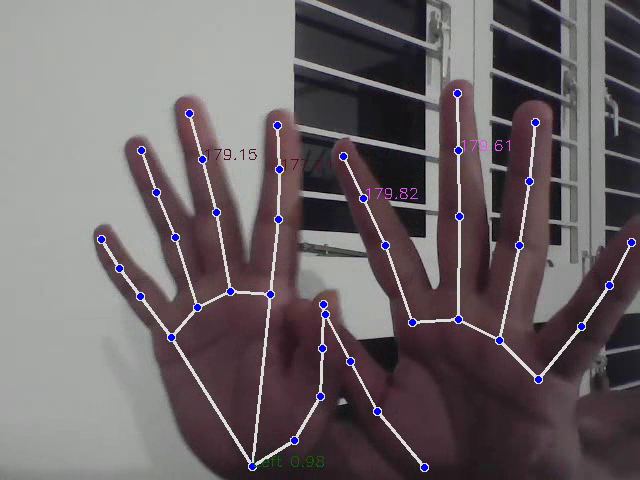

In [28]:
## show a random frame
out_cap = cv2.VideoCapture(out_video_path)
out_cap.set(cv2.CAP_PROP_POS_MSEC,np.random.randint(1500,5000)) # cue to any random second 
while True:
    success,input_frame = out_cap.read()
    if not success:
        break
    cv2_imshow(input_frame)
    break

In [25]:
a

(99, 97, 43)